In [1]:
import pandas as pa
import numpy as np
import matplotlib.pyplot as mat
import seaborn as se
import sklearn
from sklearn.pipeline import Pipeline, make_pipeline
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix,auc, roc_curve
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_selection import f_regression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder

from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings('ignore')

In [2]:
se.set_theme(style='darkgrid', palette='Accent')
pa.options.display.float_format = '{:,.2f}' .format

In [3]:
startups = pa.read_csv("/content/50_Startups.csv")

In [4]:
startups.head()

,R&D Spend,Administration,Marketing Spend,Profit
0,"165,349.20","136,897.80","471,784.10","192,261.83"
1,"162,597.70","151,377.59","443,898.53","191,792.06"
2,"153,441.51","101,145.55","407,934.54","191,050.39"
3,"144,372.41","118,671.85","383,199.62","182,901.99"
4,"142,107.34","91,391.77","366,168.42","166,187.94"


In [5]:
startups.shape

(50, 4)

In [6]:
startups.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   R&D Spend        50 non-null     float64
 1   Administration   50 non-null     float64
 2   Marketing Spend  50 non-null     float64
 3   Profit           50 non-null     float64
dtypes: float64(4)
memory usage: 1.7 KB


In [7]:
startups.isnull().sum()

R&D Spend          0
Administration     0
Marketing Spend    0
Profit             0
dtype: int64

In [8]:
startups.duplicated().any()

False

In [9]:
startups.describe()

,R&D Spend,Administration,Marketing Spend,Profit
count,50.00,50.00,50.00,50.00
mean,"73,721.62","121,344.64","211,025.10","112,012.64"
std,"45,902.26","28,017.80","122,290.31","40,306.18"
min,0.00,"51,283.14",0.00,"14,681.40"
25%,"39,936.37","103,730.88","129,300.13","90,138.90"
50%,"73,051.08","122,699.79","212,716.24","107,978.19"
75%,"101,602.80","144,842.18","299,469.08","139,765.98"
max,"165,349.20","182,645.56","471,784.10","192,261.83"


In [10]:
startups.columns.values

array(['R&D Spend', 'Administration', 'Marketing Spend', 'Profit'],
      dtype=object)

<Axes: >

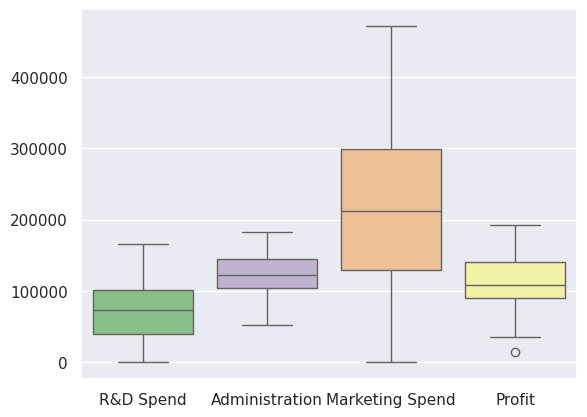

In [11]:
se.boxplot(data=startups)

In [12]:
Q3, Q1 = np.percentile(startups["Profit"], [75, 25])
IQR =Q3-Q1
startups = startups[~(startups.Profit<(Q1 - 1.5*IQR))]

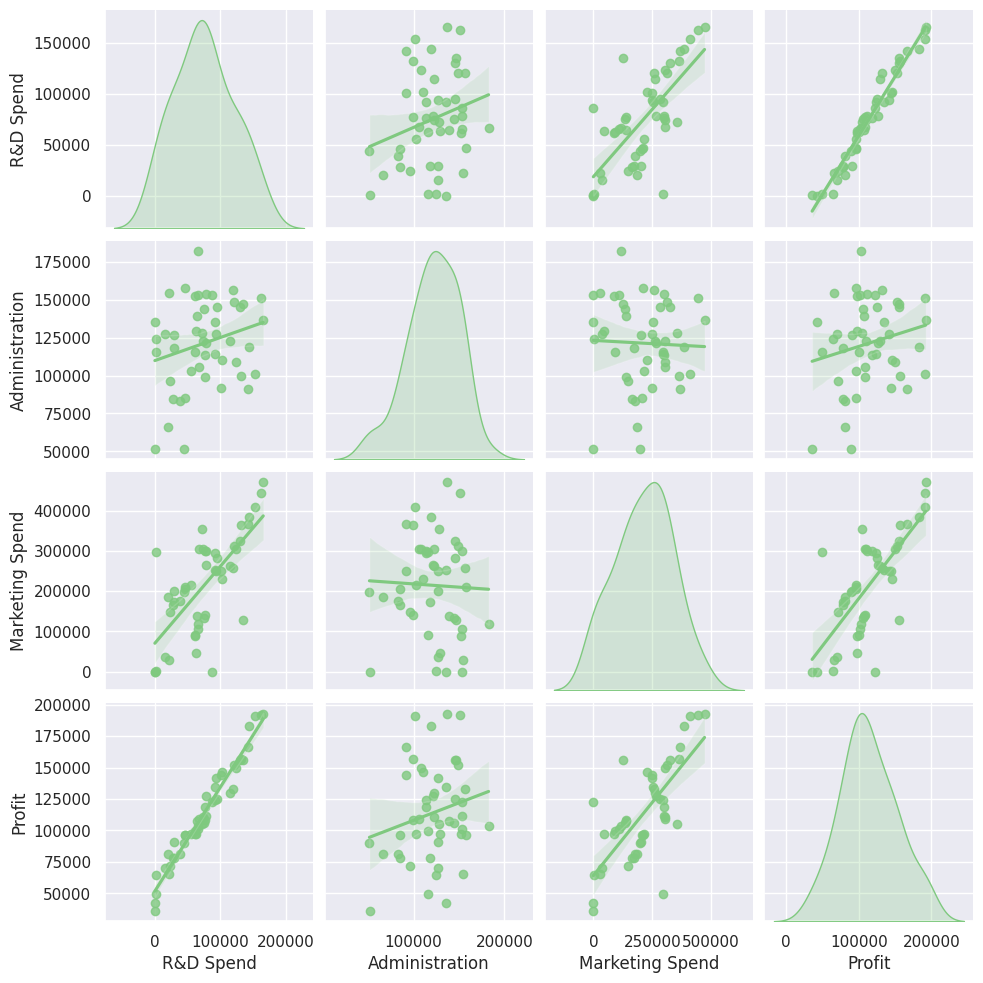

In [13]:
se.pairplot(startups[['R&D Spend', 'Administration', 'Marketing Spend', 'Profit']], kind="reg", diag_kind="kde")
mat.show()

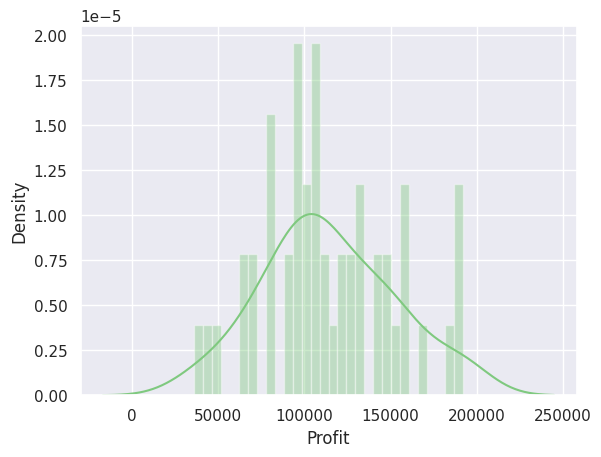

In [14]:
se.distplot(startups["Profit"], bins=30)
mat.show()

<Axes: >

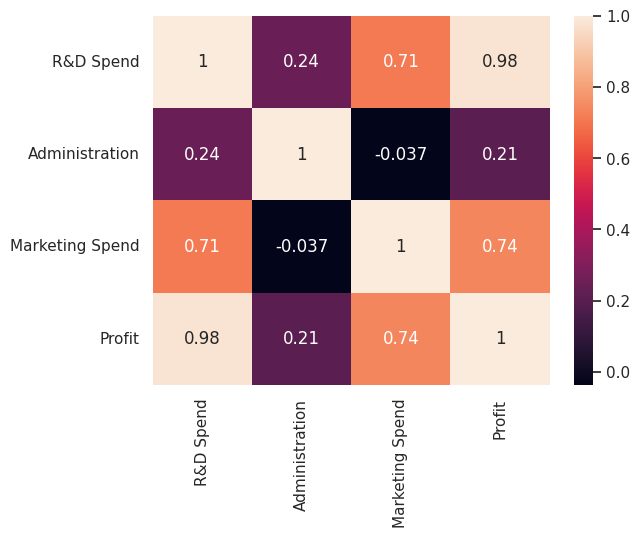

In [15]:
se.heatmap(startups.corr(), annot=True)

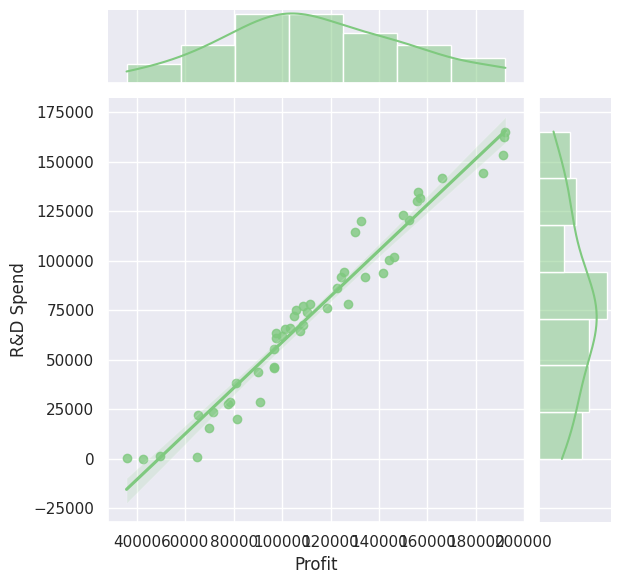

In [16]:
se.jointplot(x=startups["Profit"], y=startups["R&D Spend"], kind= "reg")
mat.show()

In [17]:
startups_prepared = startups.copy()

In [18]:
numerical = startups_prepared.drop(columns =["Profit"])
vif = pa.DataFrame()
vif["Features"] = numerical.columns
vif["VIF"] = [variance_inflation_factor(numerical.values, i) for i in range(numerical.shape[1])]
vif["VIF"] = round(vif["VIF"], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,R&D Spend,8.60
2,Marketing Spend,7.59
1,Administration,4.22


In [19]:
startups_prepared = pa.get_dummies(startups_prepared, drop_first=True)
startups_prepared.rename(columns={"R&D Spend":"R&D", "Marketing Spend":"Marketing"}, inplace=True)

In [20]:
startups_prepared.head()

,R&D,Administration,Marketing,Profit
0,"165,349.20","136,897.80","471,784.10","192,261.83"
1,"162,597.70","151,377.59","443,898.53","191,792.06"
2,"153,441.51","101,145.55","407,934.54","191,050.39"
3,"144,372.41","118,671.85","383,199.62","182,901.99"
4,"142,107.34","91,391.77","366,168.42","166,187.94"


In [21]:
X = startups_prepared.drop(columns="Profit")
Y = startups_prepared.Profit

In [22]:
data = f_regression(X[["R&D", "Administration", "Marketing"]], Y)
f_df = pa.DataFrame(data, index= [["F_statistic", "p_value"]], columns=X[["R&D", "Administration", "Marketing"]].columns).T
f_df

,F_statistic,p_value
R&D,"1,054.72",0.00
Administration,2.08,0.16
Marketing,56.66,0.00


In [23]:
X = X.drop(columns="Administration")

In [24]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=6)
sc_X =  StandardScaler()

In [25]:
sc_X =  StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

In [26]:
sc_Y = StandardScaler()
Y_train = sc_Y.fit_transform(Y_train.values.reshape(-1,1))
Y_test = sc_Y.transform(Y_test.values.reshape(-1, 1))

In [27]:
Y_train = Y_train.reshape(44)
Y_test = Y_test.reshape(5)

In [28]:
Rsqr_test = []
order = range(1,4)
for n in order:
    pr = PolynomialFeatures(degree=n)
    X_train_poly = pr.fit_transform(X_train)
    X_test_poly = pr.fit_transform(X_test)
    lr = LinearRegression()
    lr.fit(X_train_poly, Y_train)
    Rsqr_test.append(lr.score(X_test_poly, Y_test))
Rsqr_test

[0.9607037219297737, 0.9394962923773486, 0.9492791566749252]

In [29]:
lr = LinearRegression()
lr.fit(X_train, Y_train)
r2_score = lr.score(X_test, Y_test)

In [30]:
print(f"Training Accuracy score: {lr.score(X_train, Y_train) * 100:.1f}%")
print(f"Validation Accuracy score: {lr.score(X_test, Y_test) * 100:.1f}%")

Training Accuracy score: 95.9%
Validation Accuracy score: 96.1%


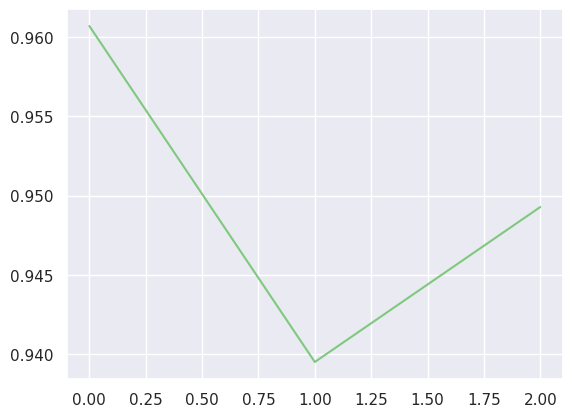

In [31]:
mat.plot(Rsqr_test)
mat.show()

In [32]:
svr = SVR()
svr.fit(X_train, Y_train)
print(f"Training Accuracy Score: {svr.score(X_train, Y_train) * 100:.1f}%")
print(f"Validation Accuracy score: {svr.score(X_test, Y_test) * 100:.1f}%")

Training Accuracy Score: 94.9%
Validation Accuracy score: 85.3%


In [33]:
dt = DecisionTreeRegressor()
dt.fit(X_train, Y_train)
print(f"Training Accuracy score: {dt.score(X_train, Y_train) * 100:.1f}%")
print(f"Validation Accuracy Score: {dt.score(X_test, Y_test) * 100:.1f}%")

Training Accuracy score: 100.0%
Validation Accuracy Score: 84.9%


In [34]:
rf = RandomForestRegressor()
rf.fit(X_train, Y_train)
print(f"Traning Accuracy score: {rf.score(X_train, Y_train) * 100:.1f}%")
print(f"Validation Accuracy score: {rf.score(X_test, Y_test) * 100:.1f}%")

Traning Accuracy score: 99.1%
Validation Accuracy score: 91.7%


In [35]:
r2_score

0.9607037219297739

In [36]:
n = X_test.shape[0]
p = X_test.shape[1]
adjusted_r2 = 1-(1-r2_score)*(n-1)/(n-p-1)
adjusted_r2

0.9214074438595479

In [37]:
Y_test_hat = lr.predict(X_test)
Y_test_hat

array([-1.742794  , -0.83409916, -0.70464199, -0.14400455,  1.17201929])

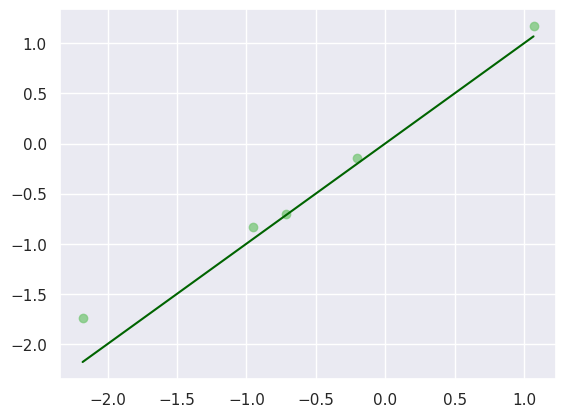

In [38]:
mat.scatter(x=Y_test, y=Y_test_hat, alpha=0.8)
mat.plot(Y_test, Y_test, color='darkgreen')
mat.show()

In [39]:
residuals = Y_test- Y_test_hat

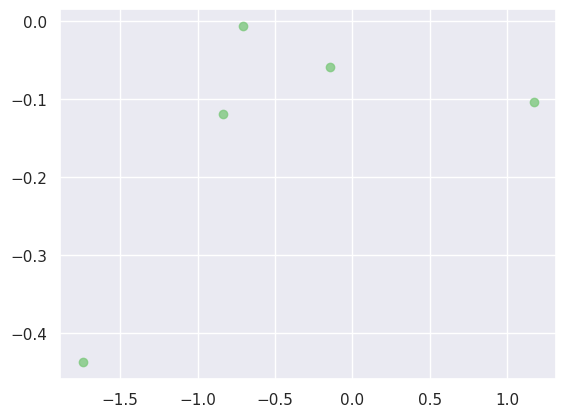

In [40]:
mat.scatter(y=residuals, x=Y_test_hat, alpha=0.8)
mat.show()

In [41]:
lr.coef_

array([0.92048117, 0.08213624])

In [43]:
lr.intercept_

2.4490625333787344e-17

In [42]:
lr.predict([[100671.96, 249744.55]])

array([113179.72248234])

In [44]:
lr.predict([[130298.1, 323876.68]])

array([146538.96110894])

In [45]:
lr.predict([[131876.9, 362861.36]])

array([151194.27192413])

In [46]:
lr.predict([[77044.01, 140574.81]])

array([82463.84715645])